## Live AirNow Snapshot (Station Level)

This section pulls the latest AirNow observations for Oregon (PM2.5 and Ozone)
and plots them as station markers. It uses the AIRNOW_KEY environment variable
and the same Oregon bounding box as the historical dashboard.


In [5]:
import os
from pathlib import Path
from datetime import datetime, timedelta, timezone

import pandas as pd
import requests

import plotly.express as px

DATA_DIR = Path("../data").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)

AIRNOW_KEY = os.getenv("AIRNOW_KEY")
BBOX = "-124.8,41.9,-116.4,46.4"          # Oregon-ish bbox
PARAMETERS = "PM25,OZONE"
AIRNOW_BASE_URL = "https://www.airnowapi.org/aq/data/"


cat_map = {
    1: "Good",
    2: "Moderate",
    3: "Unhealthy for Sensitive Groups",
    4: "Unhealthy",
    5: "Very Unhealthy",
    6: "Hazardous",
}

def fetch_airnow_current(hours_back: int = 1) -> pd.DataFrame:
    """
    Fetch recent AirNow observations (PM2.5 + Ozone) for Oregon bbox.
    Returns a cleaned DataFrame, or an empty DataFrame if nothing is returned.
    """
    if not AIRNOW_KEY:
        print("AIRNOW_KEY is not set; skipping AirNow fetch.")
        return pd.DataFrame()

    end_dt = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
    start_dt = end_dt - timedelta(hours=hours_back)

    params = {
        "format": "application/json",
        "API_KEY": AIRNOW_KEY,
        "bbox": BBOX,
        "parameters": PARAMETERS,
        "startDate": start_dt.strftime("%Y-%m-%dT%H"),
        "endDate":   end_dt.strftime("%Y-%m-%dT%H"),
        "dataType": "A",   # AQI
    }

    r = requests.get(AIRNOW_BASE_URL, params=params, timeout=60)
    try:
        r.raise_for_status()
    except requests.HTTPError as e:
        msg = f"HTTP {r.status_code} for {r.url}\nResponse text: {r.text[:300]}"
        raise RuntimeError(msg) from e

    data = r.json()
    df = pd.DataFrame(data)
    if df.empty:
        print("No AirNow rows returned; try increasing hours_back.")
        return df

    # Parse time and coerce numerics
    if "UTC" in df.columns:
        df["UTC"] = pd.to_datetime(df["UTC"], errors="coerce", utc=True)

    for c in ["AQI", "Category", "Latitude", "Longitude"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "Category" in df.columns:
        df["CategoryName"] = df["Category"].map(cat_map)

    # Keep latest record per (lat, lon, pollutant)
    if {"Latitude", "Longitude", "Parameter", "UTC"}.issubset(df.columns):
        df = (
            df.sort_values("UTC")
              .drop_duplicates(["Latitude", "Longitude", "Parameter"], keep="last")
        )

    # Optionally save a cache file
    stamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
    out_path = DATA_DIR / f"airnow_observations_or_{stamp}.parquet"
    df.to_parquet(out_path, index=False)
    print(f"Saved live AirNow snapshot → {out_path}")

    return df


Saved live AirNow snapshot → C:\Users\steve\Documents\oregon-aqi-dashboard\data\airnow_observations_or_20251206T202355Z.parquet


C:\Users\steve\AppData\Local\Temp\ipykernel_16256\1912461811.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



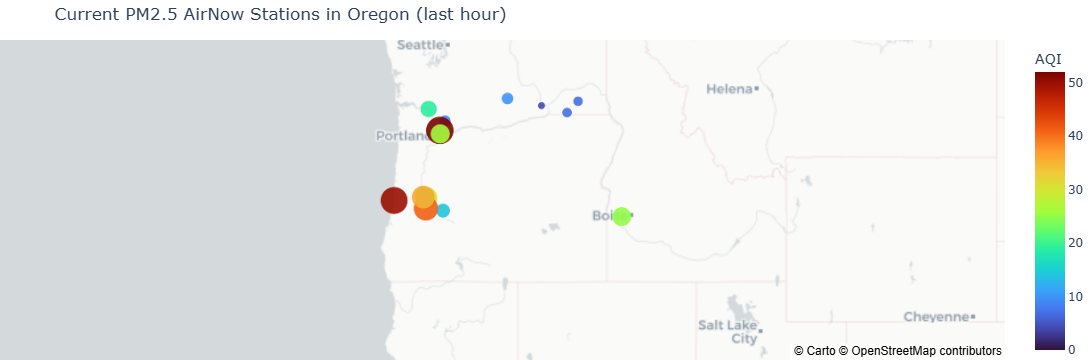

In [6]:
df_live = fetch_airnow_current(hours_back=1)

if not df_live.empty and {"Latitude","Longitude","AQI","Parameter"}.issubset(df_live.columns):
    df_live_pm25 = df_live[df_live["Parameter"] == "PM2.5"].copy()

    if df_live_pm25.empty:
        print("No PM2.5 live data in this fetch.")
    else:
        fig_live_pm25 = px.scatter_mapbox(
            df_live_pm25,
            lat="Latitude",
            lon="Longitude",
            color="AQI",
            color_continuous_scale="Turbo",
            size="AQI",
            hover_data={"Parameter": True, "CategoryName": True, "UTC": True},
            mapbox_style="carto-positron",
            zoom=4.4,
            center={"lat": 44.0, "lon": -120.5},
            opacity=0.9,
        )

        fig_live_pm25.update_layout(
            title="Current PM2.5 AirNow Stations in Oregon (last hour)",
            margin={"r": 0, "t": 40, "l": 0, "b": 0},
        )

        fig_live_pm25.show()
else:
    print("No live AirNow data to plot.")


Saved live AirNow snapshot → C:\Users\steve\Documents\oregon-aqi-dashboard\data\airnow_observations_or_20251206T202333Z.parquet


C:\Users\steve\AppData\Local\Temp\ipykernel_16256\3148778902.py:9: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



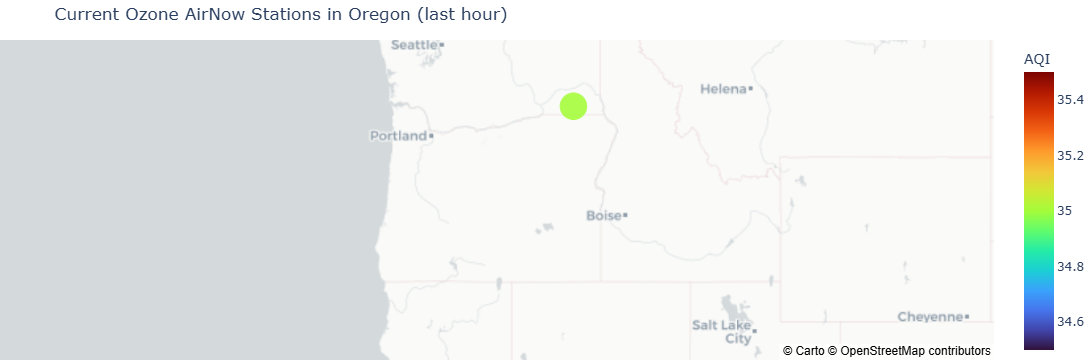

In [4]:
df_live = fetch_airnow_current(hours_back=1)

if not df_live.empty and {"Latitude","Longitude","AQI","Parameter"}.issubset(df_live.columns):
    df_live_pm25 = df_live[df_live["Parameter"] == "OZONE"].copy()

    if df_live_pm25.empty:
        print("No ozone live data in this fetch.")
    else:
        fig_live_pm25 = px.scatter_mapbox(
            df_live_pm25,
            lat="Latitude",
            lon="Longitude",
            color="AQI",
            color_continuous_scale="Turbo",
            size="AQI",
            hover_data={"Parameter": True, "CategoryName": True, "UTC": True},
            mapbox_style="carto-positron",
            zoom=4.4,
            center={"lat": 44.0, "lon": -120.5},
            opacity=0.9,
        )

        fig_live_pm25.update_layout(
            title="Current Ozone AirNow Stations in Oregon (last hour)",
            margin={"r": 0, "t": 40, "l": 0, "b": 0},
        )

        fig_live_pm25.show()
else:
    print("No live AirNow data to plot.")
